In [ ]:

"""
function ClickConnect() {
    console.log("Working");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 60000)
"""

In [ ]:
#@title Import thư viện (Chạy ô này)
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
#@title Thêm một số hàm tiện ích vào DataFrame của Pandas. (Chạy ô này)
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.3f}'.format

def mask(df, key, function):
  """Trả về một DataFrame đã lọc, bằng cách áp dụng hàm vào key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [ ]:
#@title Mã trực quan hóa (Altair) (chạy ô này)
# Các hàm sau được sử dụng để tạo biểu đồ Altair tương tác.
# Chúng ta sẽ hiển thị các biểu đồ tần số của dữ liệu, được phân chia bởi một thuộc tính nhất định.

# Một hàm tạo histogram của dữ liệu đã lọc.
def filtered_hist(field, label, filter):
  """Tạo một biểu đồ chồng của các histogram.
  Lớp đầu tiên (màu xám nhạt) chứa histogram của toàn bộ dữ liệu, và lớp thứ hai chứa histogram của dữ liệu đã lọc.
  Args:
    field: trường để tạo histogram.
    label: Nhãn chuỗi của histogram.
    filter: một đối tượng alt.Selection để sử dụng để lọc dữ liệu.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=18), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

def basic_hist(field, label):
    """Tạo một biểu đồ histogram cơ bản.
    Args:
        field: trường để tạo histogram.
        label: Nhãn chuỗi của histogram.
    """
    base = alt.Chart().mark_bar().encode(
        x=alt.X(field, bin=alt.Bin(maxbins=36), title=label),
        y="count()",
    ).properties(
        width=300,
    )
    return base.resolve_scale(y='independent')

# The movies dataset

In [ ]:
#@title Load the dataset. (Chạy ô này)

# Đường dẫn
path = '/content/drive/MyDrive/Project II/data/movies_dataset/'

ratings = pd.read_csv(path + 'ratings.csv').drop(columns='timestamp')
movies = pd.read_csv(path + 'movies_metadata.csv')
id_map = pd.read_csv(path + 'links.csv')[['movieId', 'tmdbId']].rename(columns={'tmdbId': 'id'})

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

movies['id'] = movies['id'].apply(convert_int)
id_map['id'] = id_map['id'].apply(convert_int)
indices_map = id_map.set_index('id')

import ast

# Vì một số phâm có thể thuộc nhiều thể loại, nên ta có thể tạo các cột 'genre' khác nhau như:
# - all_genres: tất cả các thể loại của bộ phim.
# - genre: lấy ngẫu nhiên từ các thể loại của bộ phim.
def mark_genres_for_tmdb(movies):
  def get_random_genre(gs):
    genres_list = ast.literal_eval(gs)
    active = [genre['name'] for genre in genres_list]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    genres_list = ast.literal_eval(gs)
    active = [genre['name'] for genre in genres_list]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = movies['genres'].apply(get_random_genre)
  movies['all_genres'] = movies['genres'].apply(get_all_genres)

mark_genres_for_tmdb(movies)
id_map = id_map.merge(movies[['title', 'id', 'genre', 'all_genres']], on='id').drop_duplicates()

<ipython-input-4-4d629b423a53>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(path + 'movies_metadata.csv')


In [ ]:
#@title Một số hàm khác
def remove_user(ratings, num):
  users_ratings = (
    ratings
    .groupby('userId', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
  )
  return ratings[~ratings['userId'].isin(users_ratings.sort_values(by='rating count').head(num)['userId'])]

def remove_movie(ratings, num):
  movies_ratings = (
    ratings
    .groupby('movieId', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
  )
  return ratings[~ratings['movieId'].isin(movies_ratings.sort_values(by='rating count').head(num)['movieId'])]

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,110,1.000
1,1,147,4.500
2,1,858,5.000
3,1,1221,5.000
4,1,1246,5.000


In [ ]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,26024289.000,135037.090,78176.197,1.000,67164.000,135163.000,202693.000,270896.000
movieId,26024289.000,15849.110,31085.258,1.000,1073.000,2583.000,6503.000,176275.000
rating,26024289.000,3.528,1.065,0.500,3.000,3.500,4.000,5.000


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 595.6 MB


In [ ]:
ratings.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [ ]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_ratings = len(ratings)
print('Số lượng user: ', num_users)
print('Số lượng movie: ', num_movies)
print('Số lượng rating: ', num_ratings)
print(f'Mật độ: {round(num_ratings / (num_users * num_movies) * 100, 2)}%')

Số lượng user:  270896
Số lượng movie:  45115
Số lượng rating:  26024289
Mật độ: 0.21%


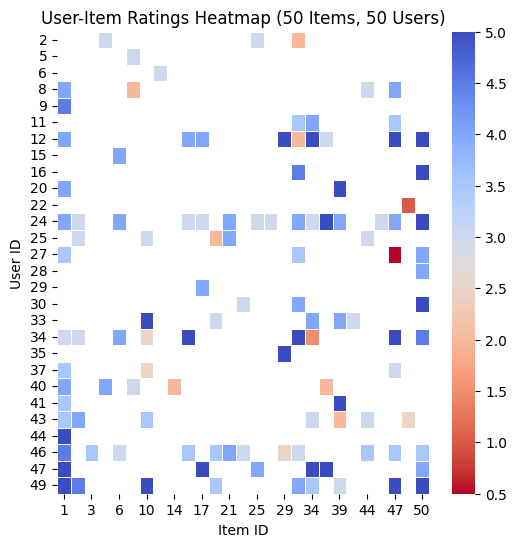

In [ ]:
# Chỉ lấy 50 item đầu tiên và 50 user đầu tiên
first_50_items = ratings.sort_values(by='movieId')['movieId'].unique()[:50]
first_50_users = ratings.sort_values(by='userId')['userId'].unique()[:50]

# Lọc dataframe chỉ chứa các rating của 50 items và 50 users đầu tiên
filtered_rating = ratings[(ratings['movieId'].isin(first_50_items)) & (ratings['userId'].isin(first_50_users))]

# Tạo ma trận rating 50x50
rating_matrix = filtered_rating.pivot(index='userId', columns='movieId', values='rating')

# Vẽ biểu đồ heatmap
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(rating_matrix, cmap="coolwarm_r", annot=False, linewidths=.5)
plt.title('User-Item Ratings Heatmap (50 Items, 50 Users)')
plt.xlabel('Item ID')
plt.ylabel('User ID')
plt.show()

## Users

In [ ]:
# data
users_ratings = (
    ratings
    .groupby('userId', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
)

# Lấy 5000 users có nhiều lượt rating nhất (nếu vượt quá 5000)
top_users_ratings = users_ratings.mask('rating count', lambda x: x < 460)

users_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,270896.000,135448.500,78201.084,1.000,67724.750,135448.500,203172.250,270896.000
rating count,270896.000,96.067,205.720,1.000,15.000,30.000,93.000,18276.000
rating mean,270896.000,3.621,0.576,0.500,3.312,3.658,4.000,5.000


In [ ]:
users_ratings.sort_values(by='rating count').head()

,userId,rating count,rating mean
236673,236674,1,5.000
251475,251476,1,3.000
227390,227391,1,4.000
55298,55299,1,4.000
118054,118055,1,4.000


In [ ]:
users_ratings.sort_values(by='rating count').tail()

,userId,rating count,rating mean
228290,228291,7410,3.220
179791,179792,7515,3.208
270122,270123,7638,2.597
8658,8659,9279,3.278
45810,45811,18276,3.199


In [ ]:
# Tạo biểu đồ cho số lượng (rating / user) và trung bình (mean user rating).
alt.hconcat(
    basic_hist('rating count', 'ratings / user'),
    basic_hist('rating mean', 'mean user rating'),
    data=top_users_ratings
)

Output hidden; open in https://colab.research.google.com to view.

## Movies

In [ ]:
#@title Data (Chạy ô này)
movies_ratings = id_map.merge(
    ratings
    .groupby('movieId', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movieId'
)

# Bộ lọc theo từng thể loại
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [ ]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genre,all_genres
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.000,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.700,5415.000,Family,Animation-Comedy-Family
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.000,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.900,2413.000,Adventure,Adventure-Fantasy-Family
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.000,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.500,92.000,Romance,Romance-Comedy


In [ ]:
movies.describe().T

,count,mean,std,min,25%,50%,75%,max
id,45463.000,108359.919,112460.749,2.000,26449.500,60003.000,157328.000,469172.000
revenue,45460.000,11209348.539,64332246.741,0.000,0.000,0.000,0.000,2787965087.000
runtime,45203.000,94.128,38.408,0.000,85.000,95.000,107.000,1256.000
vote_average,45460.000,5.618,1.924,0.000,5.000,6.000,6.800,10.000
vote_count,45460.000,109.897,491.310,0.000,3.000,10.000,34.000,14075.000


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45463 non-null  float64
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
movies.isna().sum().sort_values(ascending=False)

belongs_to_collection    40972
homepage                 37684
tagline                  25054
overview                   954
poster_path                386
runtime                    263
status                      87
release_date                87
imdb_id                     17
original_language           11
title                        6
vote_count                   6
vote_average                 6
video                        6
spoken_languages             6
revenue                      6
popularity                   5
production_companies         3
id                           3
production_countries         3
genre                        0
adult                        0
original_title               0
genres                       0
budget                       0
all_genres                   0
dtype: int64

In [ ]:
duplicates = pd.read_csv(path + 'links.csv')[['movieId', 'tmdbId']].rename(columns={'tmdbId': 'id'})

duplicates['id'] = duplicates['id'].apply(convert_int)

duplicates = duplicates.merge(movies[['title', 'id', 'genre', 'all_genres']], on='id')
duplicates = duplicates.drop_duplicates()
duplicates = duplicates[duplicates.duplicated('movieId', keep=False)]

duplicates

,movieId,id,title,genre,all_genres
140,142,NaN,NaN,Vision View Entertainment,Carousel Productions-Vision View Entertainment...
141,142,NaN,NaN,GoHands,Aniplex-GoHands-BROSTA TV-Mardock Scramble Pro...
142,142,NaN,NaN,Odyssey Media,Odyssey Media-Pulser Productions-Rogue State-T...
143,604,NaN,NaN,Vision View Entertainment,Carousel Productions-Vision View Entertainment...
144,604,NaN,NaN,GoHands,Aniplex-GoHands-BROSTA TV-Mardock Scramble Pro...
...,...,...,...,...,...
24893,175813,265189.000,Force Majeure,Comedy,Comedy-Drama
33907,142861,298721.000,Cemetery of Splendour,Fantasy,Drama-Fantasy
33908,142861,298721.000,Cemetery of Splendour,Drama,Drama-Fantasy
33909,162632,298721.000,Cemetery of Splendour,Fantasy,Drama-Fantasy


In [ ]:
movies_ratings.head()

,movieId,id,title,genre,all_genres,rating count,rating mean
0,1,862.000,Toy Story,Family,Animation-Comedy-Family,66008,3.888
1,2,8844.000,Jumanji,Adventure,Adventure-Fantasy-Family,26060,3.237
2,3,15602.000,Grumpier Old Men,Romance,Romance-Comedy,15497,3.176
3,4,31357.000,Waiting to Exhale,Comedy,Comedy-Drama-Romance,2981,2.876
4,5,11862.000,Father of the Bride Part II,Comedy,Comedy,15258,3.080


In [ ]:
movies_ratings.tail()

,movieId,id,title,genre,all_genres,rating count,rating mean
45413,176267,30840.000,Robin Hood,Drama,Drama-Action-Romance,1,4.000
45414,176269,439050.000,Subdue,Family,Drama-Family,1,3.500
45415,176271,111109.000,Century of Birthing,Drama,Drama,1,5.000
45416,176273,67758.000,Betrayal,Thriller,Action-Drama-Thriller,1,1.000
45417,176275,227506.000,Satan Triumphant,Other,Other,1,3.000


In [ ]:
movies_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,45418.000,95687.281,57277.417,1.000,47708.750,107214.000,144571.500,176275.000
id,44779.000,107334.246,112249.343,2.000,26041.000,58703.000,153832.500,469172.000
rating count,45418.000,573.137,3028.044,1.000,2.000,8.000,67.000,91921.000
rating mean,45418.000,3.061,0.733,0.500,2.688,3.162,3.500,5.000


In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
990,Forrest Gump,91921,4.053
953,The Shawshank Redemption,91082,4.429
931,Pulp Fiction,87901,4.170
1225,The Silence of the Lambs,84078,4.152
3103,The Matrix,77960,4.154
895,Star Wars,77045,4.132
1114,Jurassic Park,74355,3.660
1161,Schindler's List,67662,4.267
108,Braveheart,66512,4.016
0,Toy Story,66008,3.888


In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
39206,Planet Earth,754,4.479
953,The Shawshank Redemption,91082,4.429
43150,Band of Brothers,284,4.394
43279,Planet Earth II,95,4.353
1476,The Godfather,57070,4.340
49,The Usual Suspects,59271,4.300
1161,Schindler's List,67662,4.267
33699,Human,34,4.265
1824,The Godfather: Part II,36679,4.263
2555,Seven Samurai,13994,4.255


In [ ]:
# Lấy 5000 movies có nhiều lượt rating nhất (nếu vượt quá 5000)
top_movies_ratings = movies_ratings.mask('rating count', lambda x: x < 150)

# Hiển thị số lượng đánh giá và đánh giá trung bình của mỗi bộ phim, cùng với biểu đồ phân phối thể loại của các bộ phim.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=top_movies_ratings)

Output hidden; open in https://colab.research.google.com to view.

# Collaborative Filtering

Mục tiêu của bài toán là phân rã ma trận xếp hạng A thành tích của một ma trận nhúng người dùng $U$ và ma trận nhúng phim $V$, sao cho

$A \approx UV^\top$ , với
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ là ma trận chứa các vector nhúng người dùng
và $V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$ là ma trận chứa các vector nhúng phim.


Trong đó
- $N$ là số lượng người dùng,
- $M$ là số lượng phim,
- $A_{ij}$ là xếp hạng của bộ phim thứ j được người dùng thứ i đánh giá,
- Mỗi hàng $U_i$ là một $d$-chiều vector (embedding) đại diện cho người dùng $i$,
- Mỗi hàng $V_j$ là một $d$-chiều vector (embedding) đại diện cho bộ phim $j$,
- Dự đoán của mô hình cho cặp $(i, j)$ là tích vô hướng $\langle U_i, V_j \rangle$.



## Ma trận thưa

Ma trận xếp hạng rất lớn, nhưng hầu như các ô sẽ đều không được quan sát do 1 người dùng chỉ đánh giá một tập nhỏ của các bộ phim. Do vậy SparseTensor có thể biểu diễn hiệu quả trong trường hợp này.

In [ ]:
#@title Xây dựng hàm tạo SparseTensor cho ma trận xếp hạng
def sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: Một pd.DataFrame với các cột `userId`, `movieId` và `rating`.
  Returns:
    Một tf.SparseTensor biểu diễn ma trận xếp hạng.
  """

  indices = ratings_df[['userId', 'movieId']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users, num_movies])

## Hàm tính lỗi

Để tính toán sai số xấp xỉ của mô hình so với ma trận xếp hạng thực tế A, chúng ta sử dụng Mean Squared Error (MSE). MSE được tính dựa trên các mục đã được quan sát trong ma trận xếp hạng A. Cụ thể, MSE được định nghĩa như sau:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$

Trong đó:
- $\Omega$ là tập hợp các mục đã được quan sát trong ma trận xếp hạng A.
- $|\Omega|$ là số lượng mục trong tập hợp $\Omega$.
- $A_{ij}$ là xếp hạng của bộ phim thứ $j$ được người dùng thứ $i$ đánh giá trong ma trận xếp hạng thực tế $A$.
- $(UV^\top)_{ij}$ là ước lượng xếp hạng của phim thứ $j$ được người dùng thứ $i$ đánh giá trong ma trận xếp hạng ước lượng $UV^\top$.


In [ ]:
#@title Mean Squared Error (MSE)
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Tính toán Mean Squared Error (MSE) giữa các điểm dữ liệu thực tế và dự đoán của mô hình cho ma trận xếp hạng.

  Args:
    sparse_ratings: Ma trận xếp hạng dạng SparseTensor, có dense_shape [N, M].
    user_embeddings: Một Tensor dense U có hình dạng [N, d] với d là chiều embedding,
      trong đó U_i là embedding của người dùng i.
    movie_embeddings: Một Tensor dense V có hình dạng [M, d] với d là chiều embedding,
      trong đó V_j là embedding của phim j.

  Returns:
    Một scalar Tensor biểu diễn MSE giữa các xếp hạng thực tế và dự đoán của mô hình.
  """
  # Dự đoán xếp hạng bằng cách tính tích vô hướng giữa embedding của người dùng và phim
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)

  # Tính MSE giữa các xếp hạng thực tế và dự đoán của mô hình
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)

  return loss

# Huấn luyện mô hình

## Lớp CFModel (Collaborative Filtering Model)

Đây là một lớp đơn giản để huấn luyện một mô hình phân tách ma trận bằng stochastic gradient descent.

Constructor của lớp nhận vào các tham số sau:
- Embedding của người dùng U (một `tf.Variable`).
- Embedding của phim V (một `tf.Variable`).
- Hàm mất mát cần tối ưu (một `tf.Tensor`).
- (Tùy chọn) `list` của các metrics `dict`, mỗi một chuỗi (tên của metric) ánh xạ vào một tensor. Các metric này được đánh giá và vẽ biểu đồ trong quá trình huấn luyện (ví dụ: train_error và test_error).


Sau khi huấn luyện, người dùng có thể truy cập các embedding đã được huấn luyện bằng cách sử dụng `model.embeddings`.


Ví dụ cách sử dụng:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```




In [ ]:
# @title Lớp CFModel
class CFModel(object):
  """Lớp đơn giản đại diện cho một collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Khởi tạo một CFModel.
    Args:
      embedding_vars: Một từ điển của tf.Variables.
      loss: Một float Tensor. Hàm mất mát cần tối ưu.
      metrics: (tùy chọn) danh sách các từ điển của Tensors. Các metric trong mỗi
        từ điển sẽ được vẽ biểu đồ trong quá trình huấn luyện.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """Từ điển embeddings."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.keras.optimizers.SGD):
    """Huấn luyện mô hình.
    Args:
      num_iterations: số lượng vòng lặp.
      learning_rate: tốc độ học.
      plot_results: có vẽ biểu đồ kết quả cuối cùng trong quá trình huấn luyện hay không.
      optimizer: bộ tối ưu để sử dụng. Mặc định là GradientDescentOptimizer.
    Returns:
      Từ điển metrics được đánh giá tại vòng lặp cuối cùng.
    """
    pass


In [ ]:
#@title Tách ma trận thưa
def split_sparse_tensor(sparse_tensor, split_ratio=0.9):
  # Số lượng phần tử trong sparse tensor
  num_elements = sparse_tensor.values.shape[0]

  # Số lượng phần tử dùng cho tập huấn luyện
  num_train_elements = int(num_elements * split_ratio)

  # Chia sparse tensor thành hai phần: tập huấn luyện và tập kiểm tra
  train_indices = sparse_tensor.indices[:num_train_elements]
  train_values = sparse_tensor.values[:num_train_elements]
  train_shape = sparse_tensor.dense_shape

  test_indices = sparse_tensor.indices[num_train_elements:]
  test_values = sparse_tensor.values[num_train_elements:]
  test_shape = sparse_tensor.dense_shape

  # Tạo sparse tensor cho tập huấn luyện và tập kiểm tra
  train_sparse = tf.sparse.SparseTensor(indices=train_indices, values=train_values, dense_shape=train_shape)
  test_sparse = tf.sparse.SparseTensor(indices=test_indices, values=test_values, dense_shape=test_shape)

  return train_sparse, test_sparse

In [ ]:
#@title Lớp CFMFModel
class CFMFModel(object):
  def __init__(self, y, k, movie_embeddings = None, user_embeddings = None, lambda_ = 0.1, learning_rate = 0.1):
    self.num_movies = int(y['movieId'].max()) + 1
    self.num_users = int(y['userId'].max()) + 1
    self.k = k
    self.lambda_ = lambda_
    self.learning_rate = learning_rate
    self.m = {}  # Dictionary để lưu giá trị trung bình của mỗi user

    self.mean_normalization(y)
    self.y = sparse_tensor(y)

    if movie_embeddings is None:
      self.movie_embeddings = tf.Variable(tf.random.normal([self.num_movies, k], dtype=tf.float64, stddev=1.))
    else:
      self.movie_embeddings = movie_embeddings

    if user_embeddings is None:
      self.user_embeddings = tf.Variable(tf.random.normal([self.num_users, k], dtype=tf.float64, stddev=1.))
    else:
      self.user_embeddings = user_embeddings

  def mean_normalization(self, df):
    # Calculate mean rating for each user
    mean_ratings = df.groupby('userId')['rating'].mean()

    # Mean normalize ratings for each user
    df['rating_normalized'] = df.apply(lambda row: row['rating'] - mean_ratings[row['userId']], axis=1)

    # Store mean values by userId in dictionary
    for userId, mean_rating in mean_ratings.items():
        self.m[userId] = mean_rating


  def loss(self, sparse_ratings):
    # Dự đoán xếp hạng bằng cách tính tích vô hướng giữa embedding của người dùng và phim
    predictions = tf.reduce_sum(
      tf.gather(self.user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(self.movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)

    return tf.losses.mean_squared_error(sparse_ratings.values, predictions)

  def update_movie_embeddings(self, y):
    for m in range(self.num_movies):
      mask_indices = tf.where(tf.equal(y.indices[:, 1], m))
      r = tf.gather_nd(y.values, mask_indices)
      indices = tf.gather_nd(y.indices, mask_indices)

      grad = tf.zeros_like(self.movie_embeddings[0])
      num = 0
      for rating, indices in zip(r, indices):
        userId, movieId = indices
        rating_pred = tf.reduce_sum(tf.multiply(self.movie_embeddings[movieId], self.user_embeddings[userId]))
        diff = (rating_pred - rating).numpy().item()
        grad += diff * self.user_embeddings[userId]
        num += 1

      if num > 0:
        grad /= num
        self.movie_embeddings[movieId].assign(self.movie_embeddings[movieId] - self.learning_rate * (grad + self.lambda_ * self.movie_embeddings[m]))

  def update_user_embeddings(self, y):
    for u in range(self.num_users):
      mask_indices = tf.where(tf.equal(y.indices[:, 0], u))
      r = tf.gather_nd(y.values, mask_indices)
      indices = tf.gather_nd(y.indices, mask_indices)

      grad = tf.zeros_like(self.user_embeddings[0])
      num = 0
      for rating, indices in zip(r, indices):
        userId, movieId = indices
        rating_pred = tf.reduce_sum(tf.multiply(self.movie_embeddings[movieId], self.user_embeddings[userId]))
        diff = (rating_pred - rating).numpy().item()
        grad += diff * self.movie_embeddings[movieId]
        num += 1

      if num > 0:
        grad /= num
        self.user_embeddings[userId].assign(self.user_embeddings[userId] - self.learning_rate * (grad + self.lambda_ * self.user_embeddings[u]))

  def fit(self, max_iter=10, tol=1e-4, print_freq=1):
    prev_loss = float('inf')
    y_train, y_test = split_sparse_tensor(self.y)

    for i in range(max_iter):
      self.update_movie_embeddings(y_train)
      self.update_user_embeddings(y_train)

      train_loss = self.loss(y_train)
      test_loss = self.loss(y_test)

      if (i + 1) % print_freq == 0:
        print(f"Iteration {i+1}: Train Loss = {train_loss}, Test Loss = {test_loss}")

      if abs(train_loss - prev_loss) < tol:
        break
      prev_loss = train_loss

In [ ]:
model = CFMFModel(ratings, k=50)
model.fit()

Iteration 1: Train Loss = 45.61394587819475, Test Loss = 56.458213638801006
Iteration 2: Train Loss = 37.994376014027715, Test Loss = 54.900221492000234
Iteration 3: Train Loss = 21.34435156871579, Test Loss = 51.73872648798821
Iteration 4: Train Loss = 12.92234873145573, Test Loss = 50.433600339681206
Iteration 5: Train Loss = 9.76149109408593, Test Loss = 49.414613985978484
Iteration 6: Train Loss = 7.833646421675694, Test Loss = 48.575021192340614
Iteration 7: Train Loss = 6.284699459521305, Test Loss = 47.891509736655095
Iteration 8: Train Loss = 4.9681936666557736, Test Loss = 47.22556336200681
Iteration 9: Train Loss = 3.8618630509340246, Test Loss = 46.640498416781696
Iteration 10: Train Loss = 2.9944240261510084, Test Loss = 46.04002330144344
